In [9]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings


In [10]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.60
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = ['IRRELEVANT', 'RELEVANT'] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Balanced_Binary_Dataset'


In [11]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [12]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [13]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [14]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [15]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [16]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [17]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, requires_grad=use_pretrained)
        #num_features = model_ft.fc.in_features
        #model_ft.fc = nn.Sequential(
                   # nn.Linear(num_features, 512),
                    #nn.ReLU(),
                    #nn.Linear(512, num_classes)
                    #)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [19]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [20]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [21]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 21068 val : 5267 test : 4648


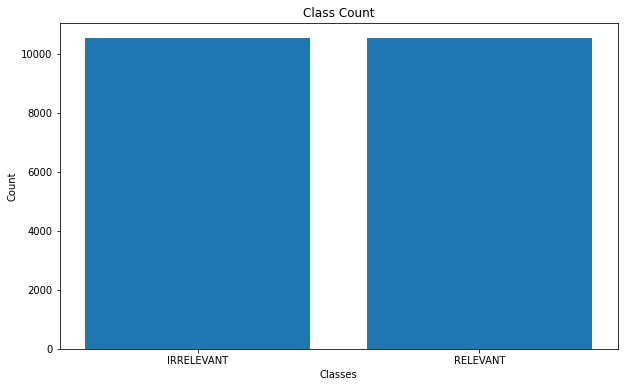

In [22]:
plot_distribution_by_class(trainset, classes)

resnet


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

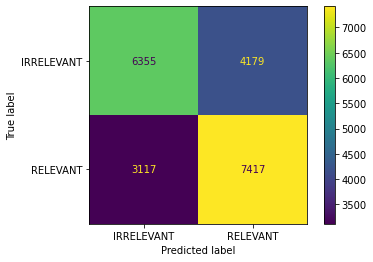

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3893 Acc: 0.7524
val Epoch Entropy: 0.9207
val Balanced Accuracy: 0.7500



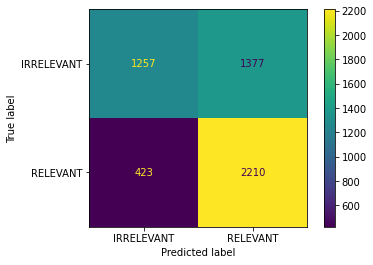

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 0.5998 Acc: 0.6803
train Epoch Entropy: 0.8526
train Balanced Accuracy: 0.8333



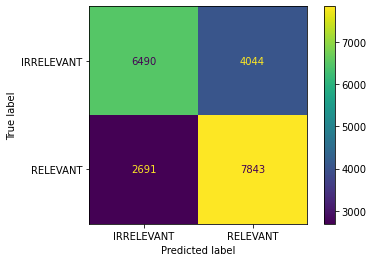

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.4733 Acc: 0.7682
val Epoch Entropy: 0.9646
val Balanced Accuracy: 0.5000



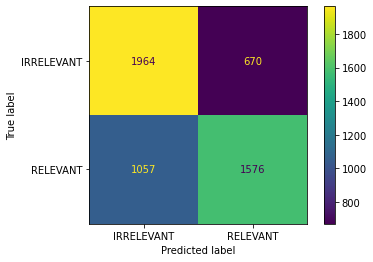

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 0.5843 Acc: 0.6972
train Epoch Entropy: 0.8346
train Balanced Accuracy: 0.8333



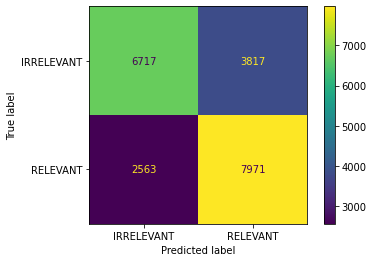

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3409 Acc: 0.7750
val Epoch Entropy: 0.8506
val Balanced Accuracy: 1.0000



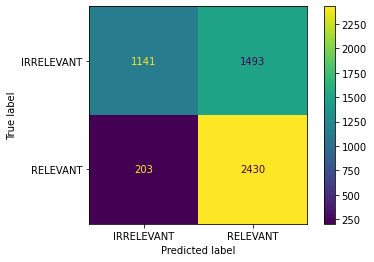

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 0.5666 Acc: 0.7079
train Epoch Entropy: 0.8093
train Balanced Accuracy: 0.8333



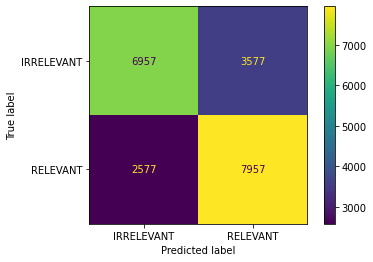

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.4070 Acc: 0.8370
val Epoch Entropy: 0.9236
val Balanced Accuracy: 1.0000



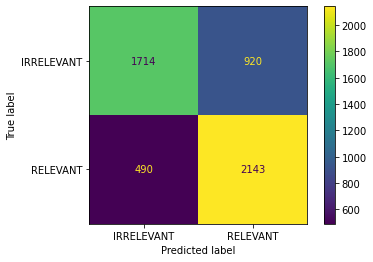

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 0.5495 Acc: 0.7223
train Epoch Entropy: 0.7857
train Balanced Accuracy: 1.0000



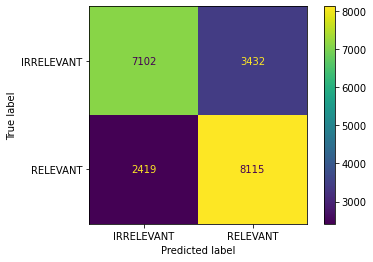

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3902 Acc: 0.8268
val Epoch Entropy: 0.8696
val Balanced Accuracy: 1.0000



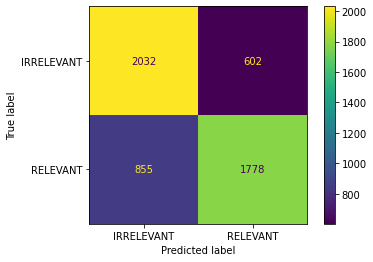

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 0.5392 Acc: 0.7300
train Epoch Entropy: 0.7722
train Balanced Accuracy: 1.0000



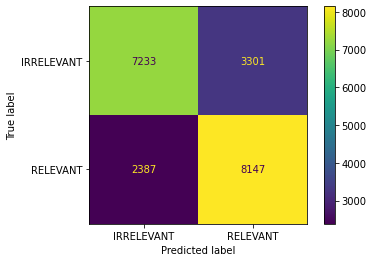

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3209 Acc: 0.8385
val Epoch Entropy: 0.8131
val Balanced Accuracy: 0.5000



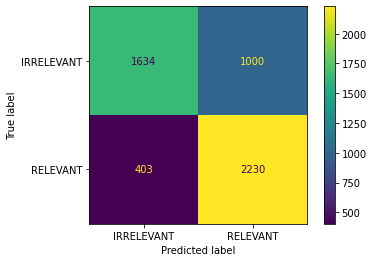

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 0.5302 Acc: 0.7366
train Epoch Entropy: 0.7598
train Balanced Accuracy: 0.8333



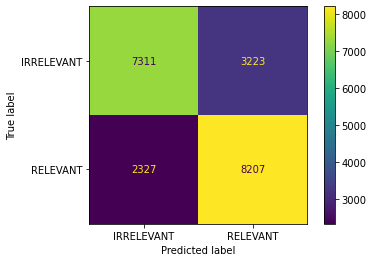

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3441 Acc: 0.8420
val Epoch Entropy: 0.8399
val Balanced Accuracy: 1.0000



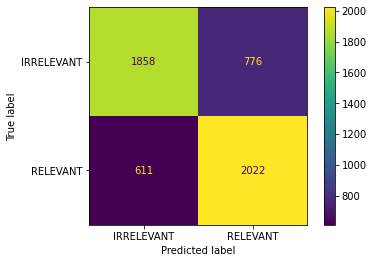

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 0.5256 Acc: 0.7408
train Epoch Entropy: 0.7543
train Balanced Accuracy: 0.6667



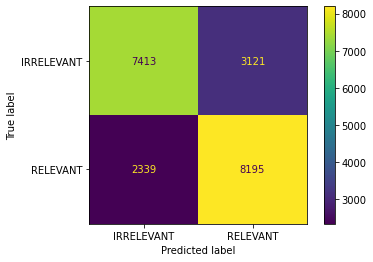

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3753 Acc: 0.8485
val Epoch Entropy: 0.8570
val Balanced Accuracy: 0.7500



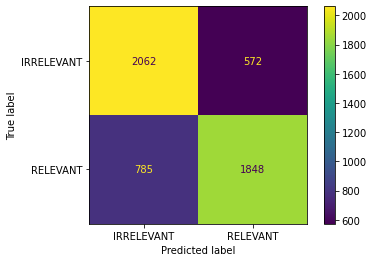

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 0.5183 Acc: 0.7429
train Epoch Entropy: 0.7440
train Balanced Accuracy: 0.5000



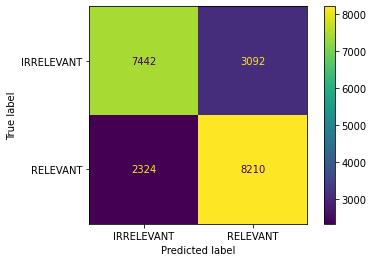

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3389 Acc: 0.8427
val Epoch Entropy: 0.8149
val Balanced Accuracy: 1.0000



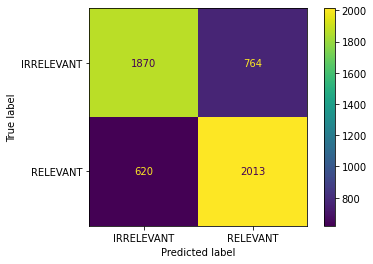

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 0.5050 Acc: 0.7526
train Epoch Entropy: 0.7319
train Balanced Accuracy: 0.5000



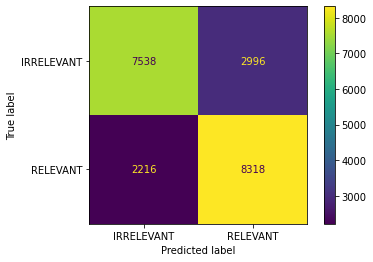

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3392 Acc: 0.8583
val Epoch Entropy: 0.8234
val Balanced Accuracy: 0.7500



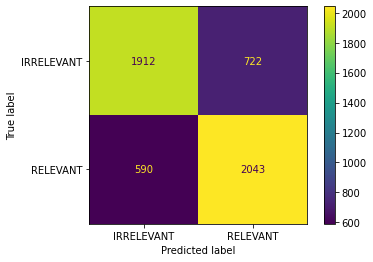

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 0.4991 Acc: 0.7537
train Epoch Entropy: 0.7268
train Balanced Accuracy: 1.0000



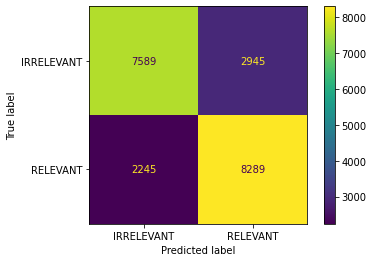

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3365 Acc: 0.8529
val Epoch Entropy: 0.8173
val Balanced Accuracy: 0.5000



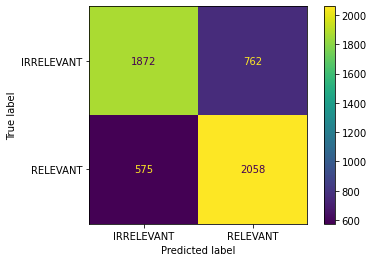

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 0.4951 Acc: 0.7581
train Epoch Entropy: 0.7208
train Balanced Accuracy: 0.5000



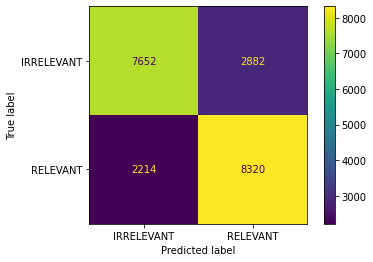

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3271 Acc: 0.8520
val Epoch Entropy: 0.8059
val Balanced Accuracy: 0.6667



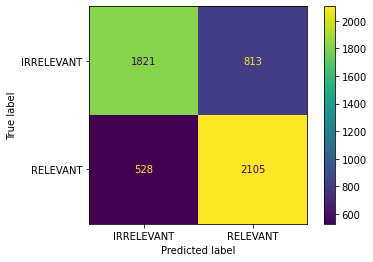

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 0.4953 Acc: 0.7580
train Epoch Entropy: 0.7179
train Balanced Accuracy: 1.0000



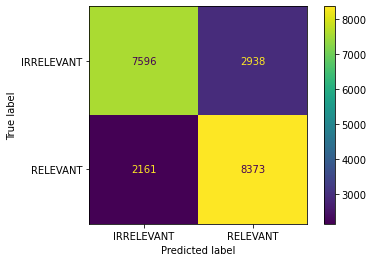

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3405 Acc: 0.8526
val Epoch Entropy: 0.8224
val Balanced Accuracy: 0.2500



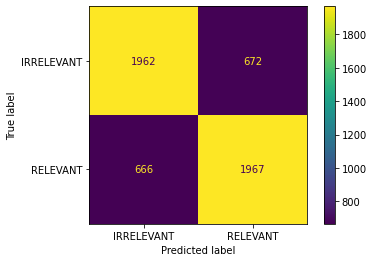

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 0.4927 Acc: 0.7569
train Epoch Entropy: 0.7195
train Balanced Accuracy: 0.5000



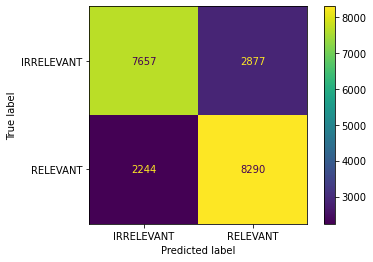

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3323 Acc: 0.8613
val Epoch Entropy: 0.8114
val Balanced Accuracy: 0.3333



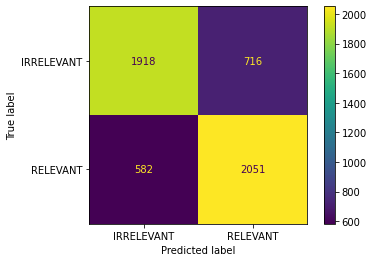

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 0.4923 Acc: 0.7600
train Epoch Entropy: 0.7156
train Balanced Accuracy: 0.7500



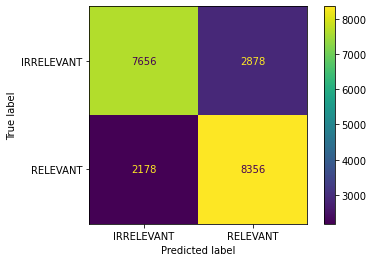

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3269 Acc: 0.8557
val Epoch Entropy: 0.8026
val Balanced Accuracy: 0.7500



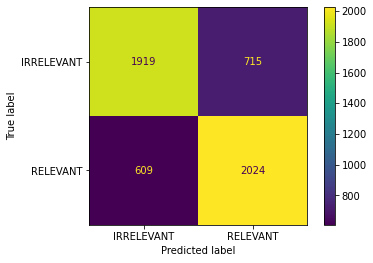

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 0.4937 Acc: 0.7580
train Epoch Entropy: 0.7180
train Balanced Accuracy: 0.8333



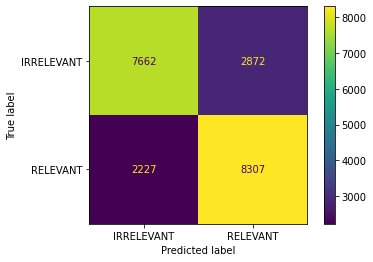

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3320 Acc: 0.8639
val Epoch Entropy: 0.8133
val Balanced Accuracy: 0.7500



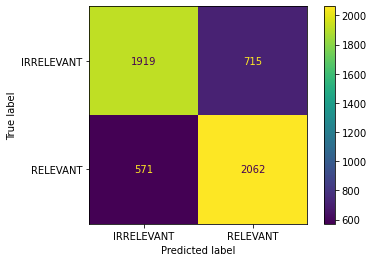

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 0.4920 Acc: 0.7588
train Epoch Entropy: 0.7173
train Balanced Accuracy: 0.7500



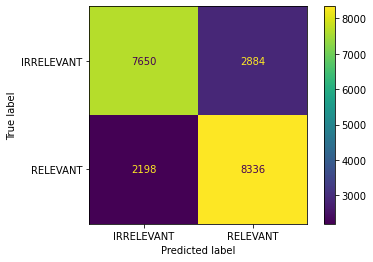

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3321 Acc: 0.8589
val Epoch Entropy: 0.8097
val Balanced Accuracy: 0.0000



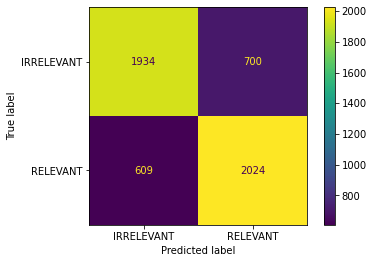

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------

train Loss: 0.4921 Acc: 0.7575
train Epoch Entropy: 0.7173
train Balanced Accuracy: 0.5000



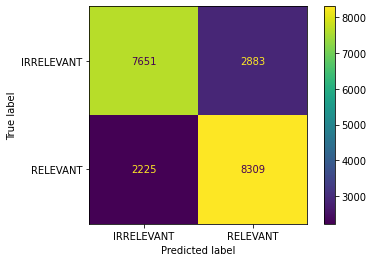

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3287 Acc: 0.8615
val Epoch Entropy: 0.8048
val Balanced Accuracy: 1.0000



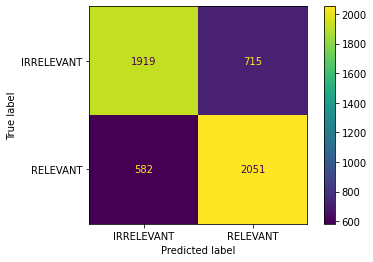

<Figure size 576x432 with 0 Axes>

Epoch 18/59
----------

train Loss: 0.4918 Acc: 0.7595
train Epoch Entropy: 0.7143
train Balanced Accuracy: 0.8333



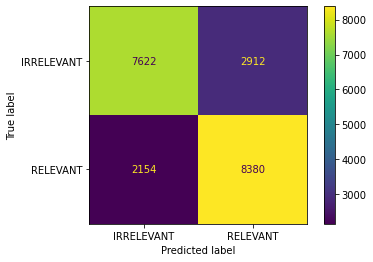

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3306 Acc: 0.8550
val Epoch Entropy: 0.8078
val Balanced Accuracy: 0.0000



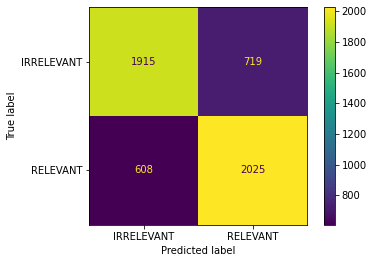

<Figure size 576x432 with 0 Axes>

Epoch 19/59
----------

train Loss: 0.4914 Acc: 0.7594
train Epoch Entropy: 0.7145
train Balanced Accuracy: 1.0000



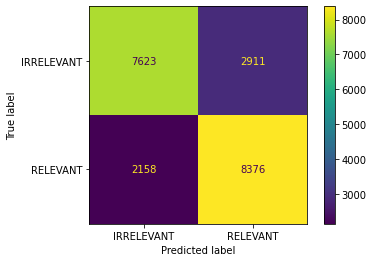

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3290 Acc: 0.8609
val Epoch Entropy: 0.8064
val Balanced Accuracy: 1.0000



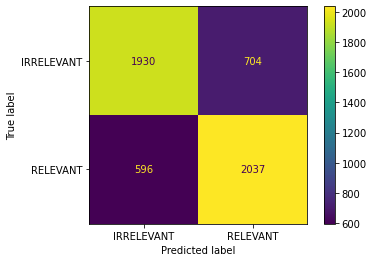

<Figure size 576x432 with 0 Axes>

Epoch 20/59
----------

train Loss: 0.4901 Acc: 0.7581
train Epoch Entropy: 0.7151
train Balanced Accuracy: 1.0000



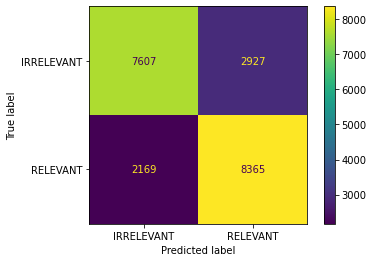

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3336 Acc: 0.8583
val Epoch Entropy: 0.8158
val Balanced Accuracy: 0.6667



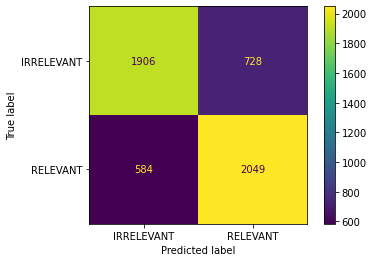

<Figure size 576x432 with 0 Axes>

Epoch 21/59
----------

train Loss: 0.4907 Acc: 0.7607
train Epoch Entropy: 0.7148
train Balanced Accuracy: 1.0000



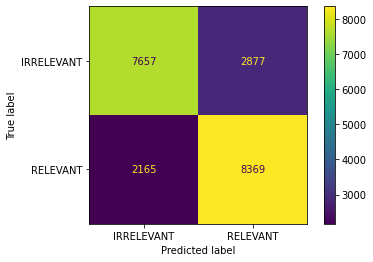

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3286 Acc: 0.8583
val Epoch Entropy: 0.8034
val Balanced Accuracy: 1.0000



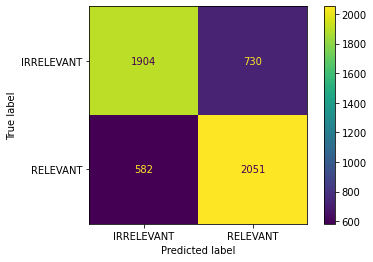

<Figure size 576x432 with 0 Axes>

Epoch 22/59
----------

train Loss: 0.4906 Acc: 0.7606
train Epoch Entropy: 0.7151
train Balanced Accuracy: 0.8333



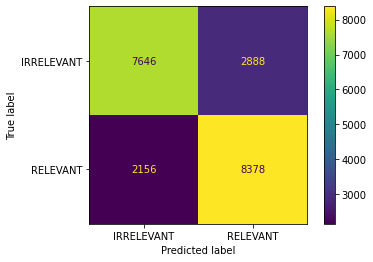

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3350 Acc: 0.8618
val Epoch Entropy: 0.8129
val Balanced Accuracy: 0.3333



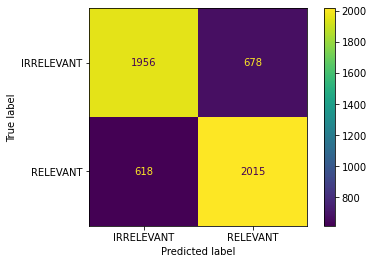

<Figure size 576x432 with 0 Axes>

Epoch 23/59
----------

train Loss: 0.4930 Acc: 0.7587
train Epoch Entropy: 0.7155
train Balanced Accuracy: 1.0000



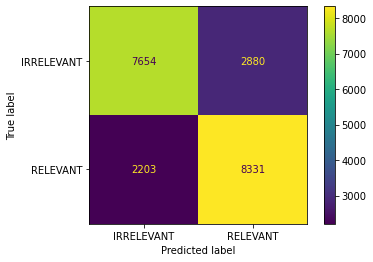

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3357 Acc: 0.8574
val Epoch Entropy: 0.8159
val Balanced Accuracy: 0.2500



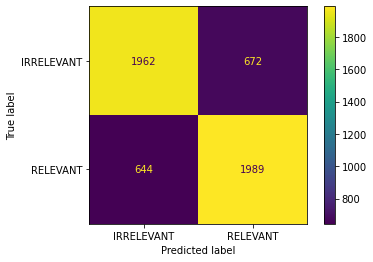

<Figure size 576x432 with 0 Axes>

Epoch 24/59
----------

train Loss: 0.4931 Acc: 0.7609
train Epoch Entropy: 0.7147
train Balanced Accuracy: 0.8333



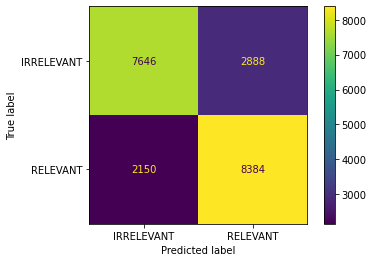

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3315 Acc: 0.8626
val Epoch Entropy: 0.8115
val Balanced Accuracy: 0.5000



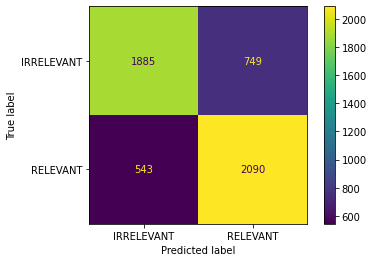

<Figure size 576x432 with 0 Axes>

Epoch 25/59
----------

train Loss: 0.4905 Acc: 0.7599
train Epoch Entropy: 0.7153
train Balanced Accuracy: 0.7500



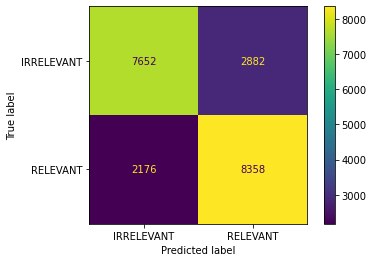

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3251 Acc: 0.8628
val Epoch Entropy: 0.7967
val Balanced Accuracy: 1.0000



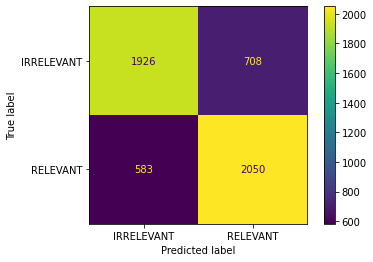

<Figure size 576x432 with 0 Axes>

Epoch 26/59
----------

train Loss: 0.4935 Acc: 0.7581
train Epoch Entropy: 0.7154
train Balanced Accuracy: 0.8333



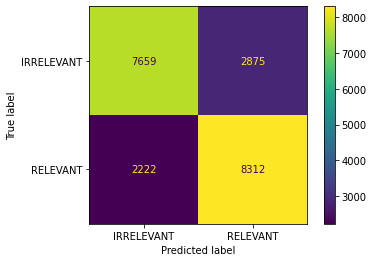

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3312 Acc: 0.8592
val Epoch Entropy: 0.8093
val Balanced Accuracy: 1.0000



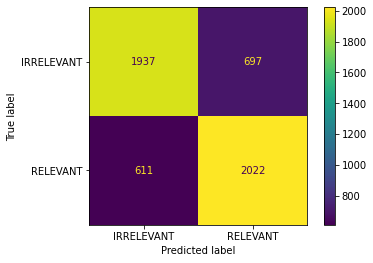

<Figure size 576x432 with 0 Axes>

Epoch 27/59
----------

train Loss: 0.4914 Acc: 0.7587
train Epoch Entropy: 0.7144
train Balanced Accuracy: 0.8333



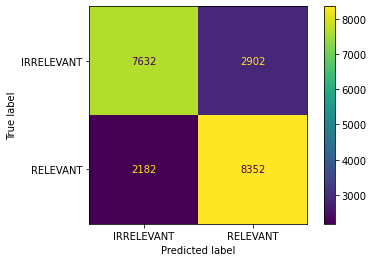

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3367 Acc: 0.8555
val Epoch Entropy: 0.8181
val Balanced Accuracy: 1.0000



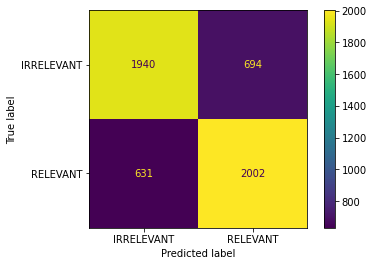

<Figure size 576x432 with 0 Axes>

Epoch 28/59
----------

train Loss: 0.4899 Acc: 0.7612
train Epoch Entropy: 0.7150
train Balanced Accuracy: 1.0000



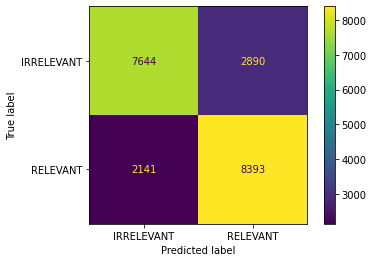

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3300 Acc: 0.8572
val Epoch Entropy: 0.8070
val Balanced Accuracy: 1.0000



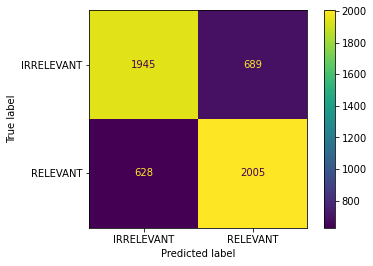

<Figure size 576x432 with 0 Axes>

Epoch 29/59
----------

train Loss: 0.4911 Acc: 0.7612
train Epoch Entropy: 0.7149
train Balanced Accuracy: 0.7500



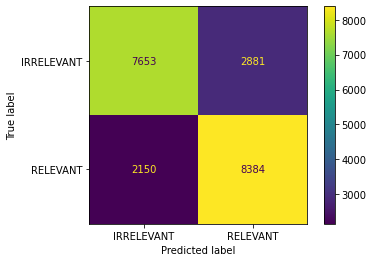

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3279 Acc: 0.8639
val Epoch Entropy: 0.8068
val Balanced Accuracy: 0.7500



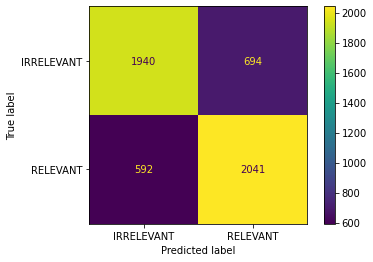

<Figure size 576x432 with 0 Axes>

Epoch 30/59
----------

train Loss: 0.4907 Acc: 0.7618
train Epoch Entropy: 0.7152
train Balanced Accuracy: 1.0000



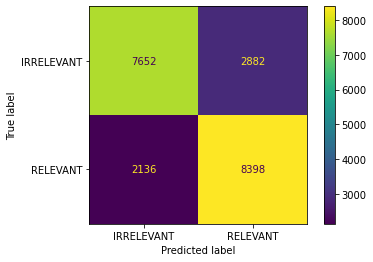

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3307 Acc: 0.8635
val Epoch Entropy: 0.8081
val Balanced Accuracy: 0.7500



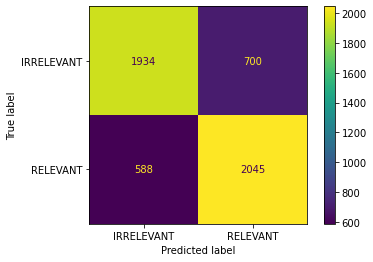

<Figure size 576x432 with 0 Axes>

Epoch 31/59
----------

train Loss: 0.4899 Acc: 0.7614
train Epoch Entropy: 0.7157
train Balanced Accuracy: 0.7500



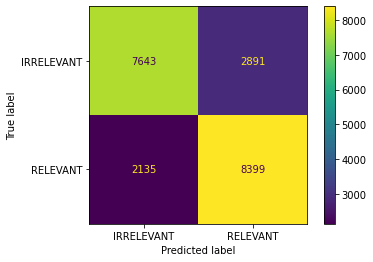

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3276 Acc: 0.8524
val Epoch Entropy: 0.8024
val Balanced Accuracy: 1.0000



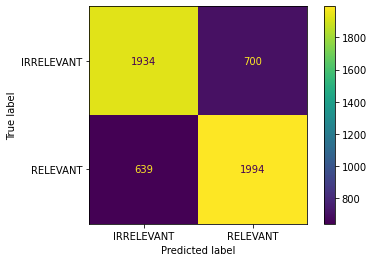

<Figure size 576x432 with 0 Axes>

Epoch 32/59
----------

train Loss: 0.4923 Acc: 0.7598
train Epoch Entropy: 0.7154
train Balanced Accuracy: 0.8333



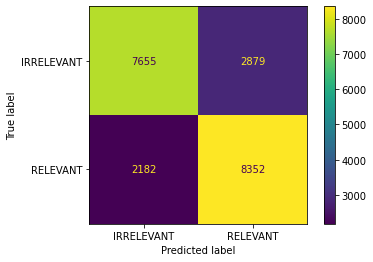

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3281 Acc: 0.8594
val Epoch Entropy: 0.8043
val Balanced Accuracy: 1.0000



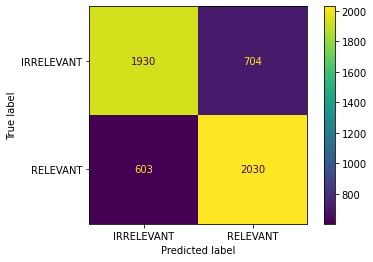

<Figure size 576x432 with 0 Axes>

Epoch 33/59
----------

train Loss: 0.4910 Acc: 0.7613
train Epoch Entropy: 0.7158
train Balanced Accuracy: 0.3333



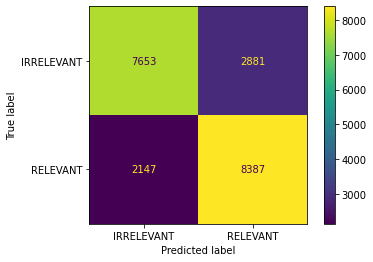

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3302 Acc: 0.8587
val Epoch Entropy: 0.8079
val Balanced Accuracy: 0.7500



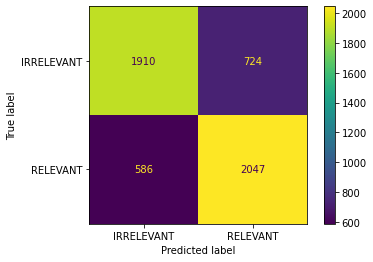

<Figure size 576x432 with 0 Axes>

Epoch 34/59
----------

train Loss: 0.4920 Acc: 0.7587
train Epoch Entropy: 0.7144
train Balanced Accuracy: 0.6667



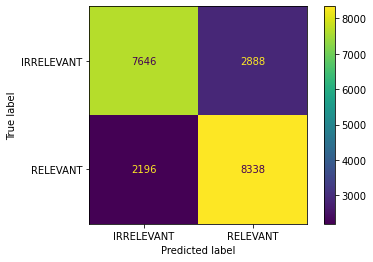

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3309 Acc: 0.8611
val Epoch Entropy: 0.8092
val Balanced Accuracy: 1.0000



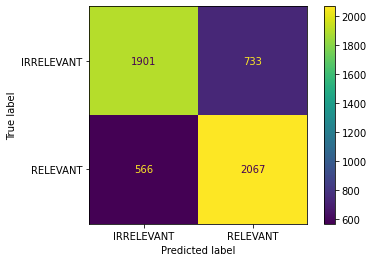

<Figure size 576x432 with 0 Axes>

Epoch 35/59
----------

train Loss: 0.4903 Acc: 0.7617
train Epoch Entropy: 0.7143
train Balanced Accuracy: 1.0000



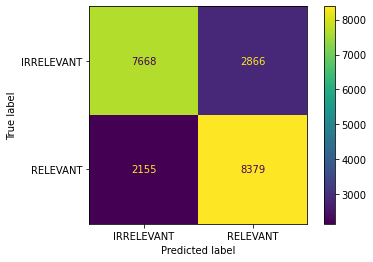

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3311 Acc: 0.8576
val Epoch Entropy: 0.8084
val Balanced Accuracy: 0.5000



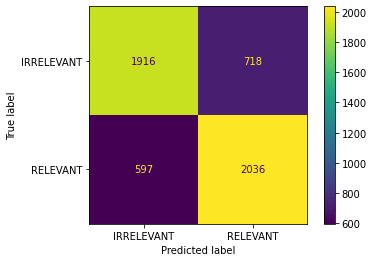

<Figure size 576x432 with 0 Axes>

Epoch 36/59
----------

train Loss: 0.4925 Acc: 0.7618
train Epoch Entropy: 0.7151
train Balanced Accuracy: 0.7500



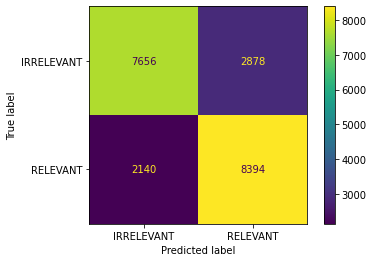

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3283 Acc: 0.8609
val Epoch Entropy: 0.8057
val Balanced Accuracy: 1.0000



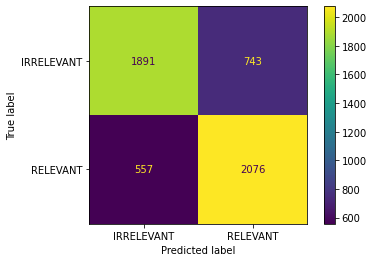

<Figure size 576x432 with 0 Axes>

Epoch 37/59
----------

train Loss: 0.4907 Acc: 0.7601
train Epoch Entropy: 0.7154
train Balanced Accuracy: 0.8333



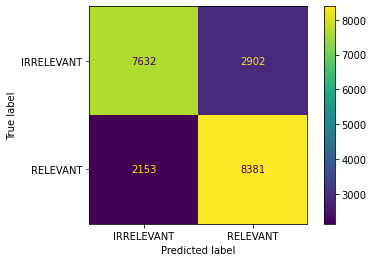

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3251 Acc: 0.8557
val Epoch Entropy: 0.7977
val Balanced Accuracy: 0.6667



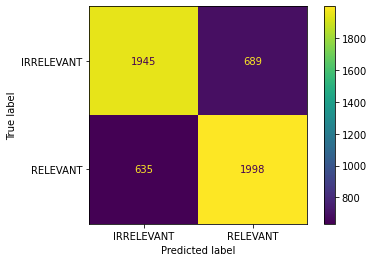

<Figure size 576x432 with 0 Axes>

Epoch 38/59
----------

train Loss: 0.4901 Acc: 0.7603
train Epoch Entropy: 0.7149
train Balanced Accuracy: 0.8333



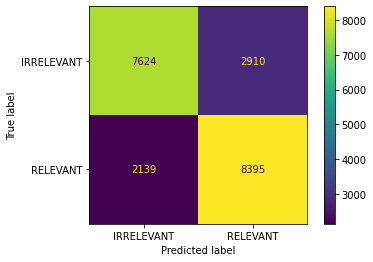

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3351 Acc: 0.8596
val Epoch Entropy: 0.8150
val Balanced Accuracy: 1.0000



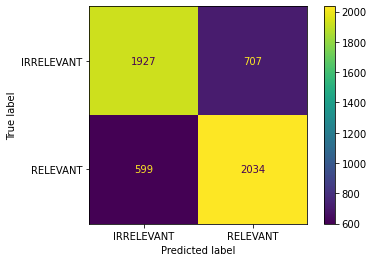

<Figure size 576x432 with 0 Axes>

Epoch 39/59
----------

train Loss: 0.4891 Acc: 0.7616
train Epoch Entropy: 0.7141
train Balanced Accuracy: 0.3333



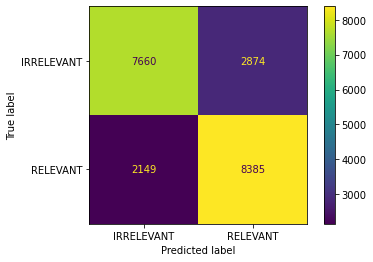

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3377 Acc: 0.8555
val Epoch Entropy: 0.8162
val Balanced Accuracy: 0.5000



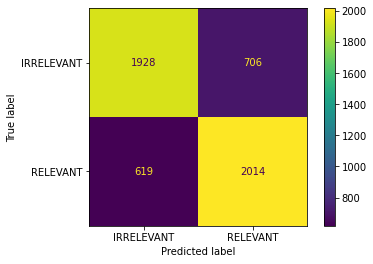

<Figure size 576x432 with 0 Axes>

Epoch 40/59
----------

train Loss: 0.4916 Acc: 0.7583
train Epoch Entropy: 0.7139
train Balanced Accuracy: 1.0000



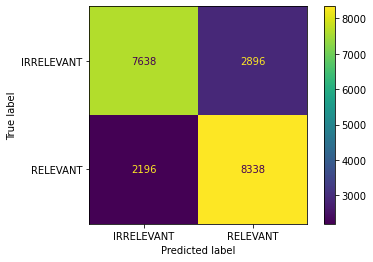

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3295 Acc: 0.8581
val Epoch Entropy: 0.8067
val Balanced Accuracy: 0.5000



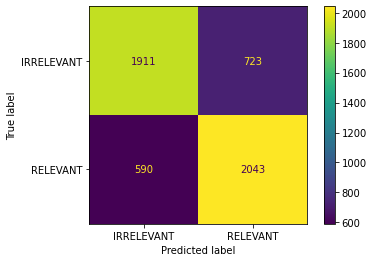

<Figure size 576x432 with 0 Axes>

Epoch 41/59
----------

train Loss: 0.4906 Acc: 0.7602
train Epoch Entropy: 0.7148
train Balanced Accuracy: 1.0000



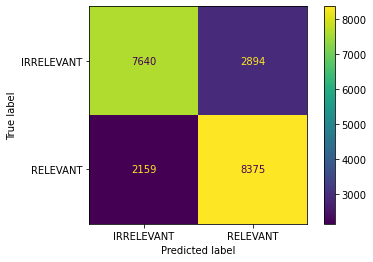

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3278 Acc: 0.8594
val Epoch Entropy: 0.8052
val Balanced Accuracy: 0.7500



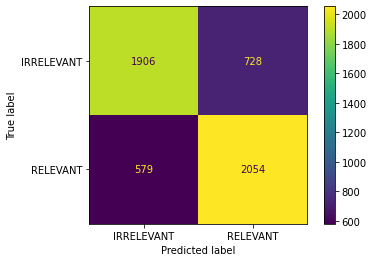

<Figure size 576x432 with 0 Axes>

Epoch 42/59
----------

train Loss: 0.4911 Acc: 0.7590
train Epoch Entropy: 0.7143
train Balanced Accuracy: 0.5000



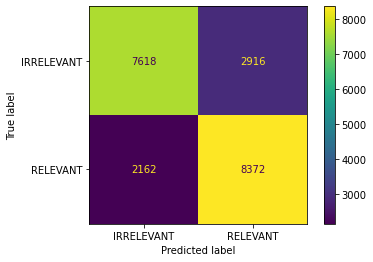

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3258 Acc: 0.8563
val Epoch Entropy: 0.8009
val Balanced Accuracy: 0.7500



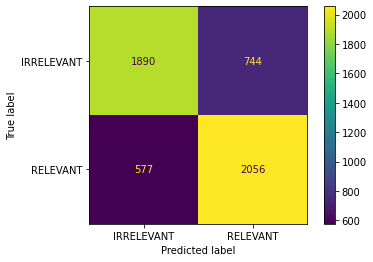

<Figure size 576x432 with 0 Axes>

Epoch 43/59
----------

train Loss: 0.4895 Acc: 0.7612
train Epoch Entropy: 0.7150
train Balanced Accuracy: 0.5000



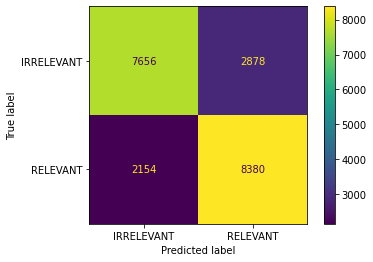

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3258 Acc: 0.8589
val Epoch Entropy: 0.8025
val Balanced Accuracy: 0.2500



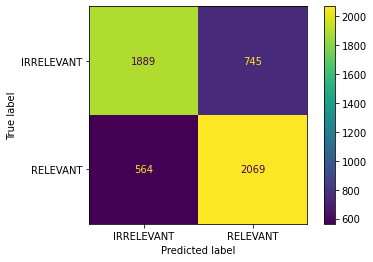

<Figure size 576x432 with 0 Axes>

Epoch 44/59
----------

train Loss: 0.4912 Acc: 0.7593
train Epoch Entropy: 0.7156
train Balanced Accuracy: 0.7500



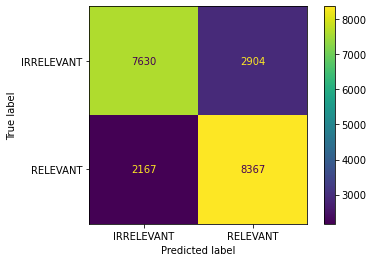

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3224 Acc: 0.8583
val Epoch Entropy: 0.7957
val Balanced Accuracy: 0.5000



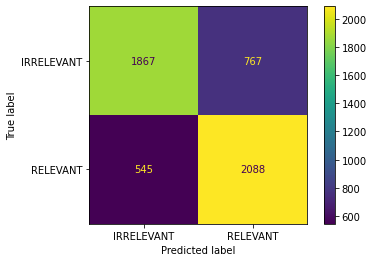

<Figure size 576x432 with 0 Axes>

Epoch 45/59
----------

train Loss: 0.4896 Acc: 0.7616
train Epoch Entropy: 0.7158
train Balanced Accuracy: 0.7500



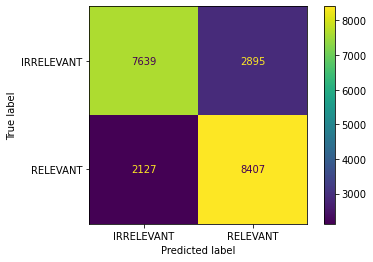

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3307 Acc: 0.8626
val Epoch Entropy: 0.8071
val Balanced Accuracy: 1.0000



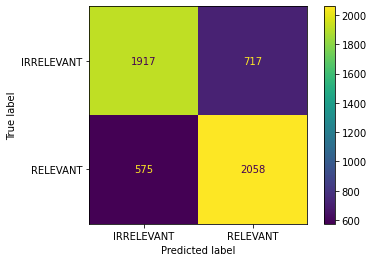

<Figure size 576x432 with 0 Axes>

Epoch 46/59
----------

train Loss: 0.4917 Acc: 0.7604
train Epoch Entropy: 0.7148
train Balanced Accuracy: 0.7500



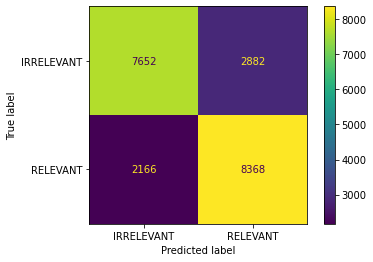

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3340 Acc: 0.8587
val Epoch Entropy: 0.8139
val Balanced Accuracy: 1.0000



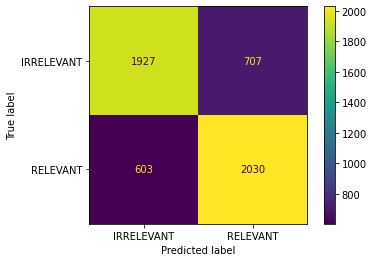

<Figure size 576x432 with 0 Axes>

Epoch 47/59
----------

train Loss: 0.4932 Acc: 0.7605
train Epoch Entropy: 0.7150
train Balanced Accuracy: 0.2500



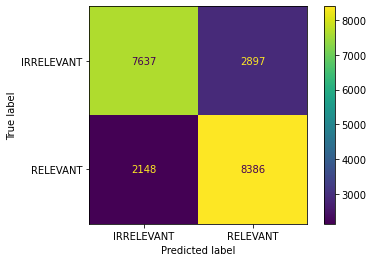

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3347 Acc: 0.8546
val Epoch Entropy: 0.8120
val Balanced Accuracy: 0.5000



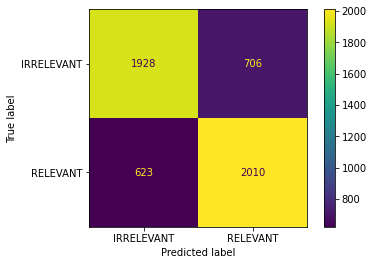

<Figure size 576x432 with 0 Axes>

Epoch 48/59
----------

train Loss: 0.4914 Acc: 0.7612
train Epoch Entropy: 0.7151
train Balanced Accuracy: 1.0000



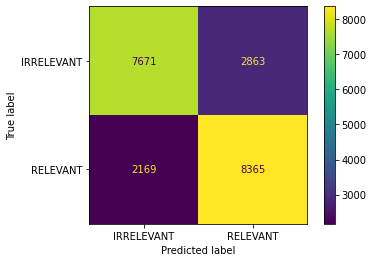

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3288 Acc: 0.8639
val Epoch Entropy: 0.8046
val Balanced Accuracy: 1.0000



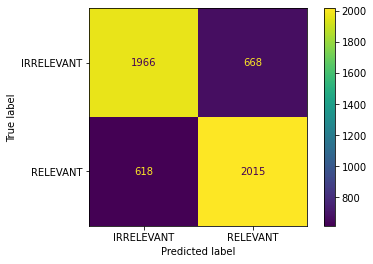

<Figure size 576x432 with 0 Axes>

Epoch 49/59
----------

train Loss: 0.4904 Acc: 0.7618
train Epoch Entropy: 0.7148
train Balanced Accuracy: 1.0000



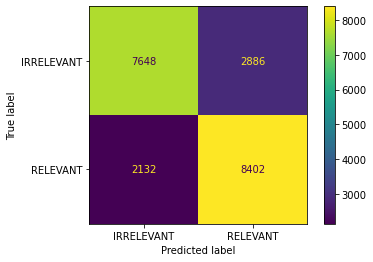

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3306 Acc: 0.8607
val Epoch Entropy: 0.8078
val Balanced Accuracy: 0.7500



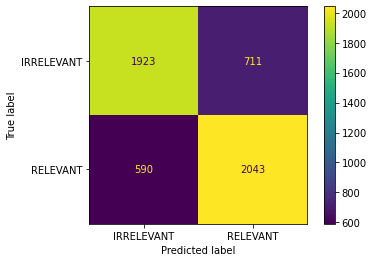

<Figure size 576x432 with 0 Axes>

Epoch 50/59
----------

train Loss: 0.4910 Acc: 0.7602
train Epoch Entropy: 0.7148
train Balanced Accuracy: 0.7500



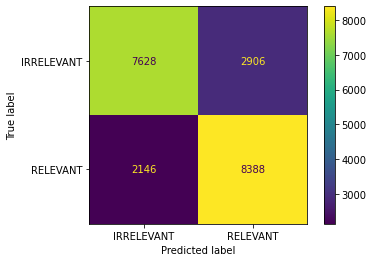

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3333 Acc: 0.8622
val Epoch Entropy: 0.8110
val Balanced Accuracy: 1.0000



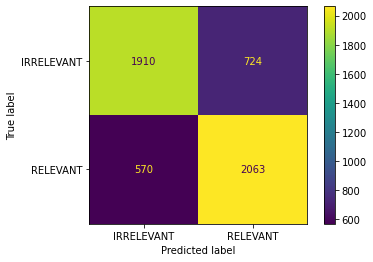

<Figure size 576x432 with 0 Axes>

Epoch 51/59
----------

train Loss: 0.4908 Acc: 0.7608
train Epoch Entropy: 0.7151
train Balanced Accuracy: 1.0000



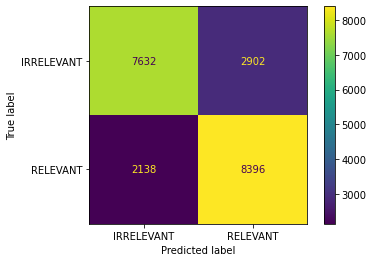

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3390 Acc: 0.8600
val Epoch Entropy: 0.8184
val Balanced Accuracy: 1.0000



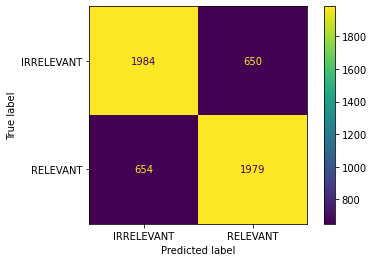

<Figure size 576x432 with 0 Axes>

Epoch 52/59
----------

train Loss: 0.4923 Acc: 0.7574
train Epoch Entropy: 0.7146
train Balanced Accuracy: 0.8333



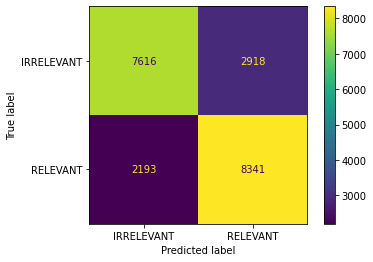

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3352 Acc: 0.8559
val Epoch Entropy: 0.8121
val Balanced Accuracy: 1.0000



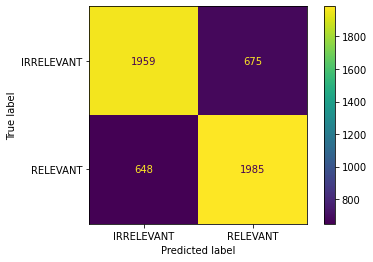

<Figure size 576x432 with 0 Axes>

Epoch 53/59
----------

train Loss: 0.4910 Acc: 0.7617
train Epoch Entropy: 0.7138
train Balanced Accuracy: 1.0000



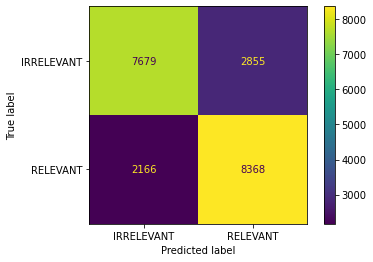

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3402 Acc: 0.8602
val Epoch Entropy: 0.8206
val Balanced Accuracy: 0.6667



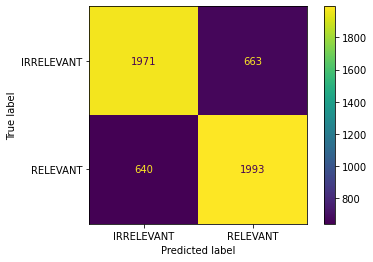

<Figure size 576x432 with 0 Axes>

Epoch 54/59
----------

train Loss: 0.4919 Acc: 0.7597
train Epoch Entropy: 0.7152
train Balanced Accuracy: 1.0000



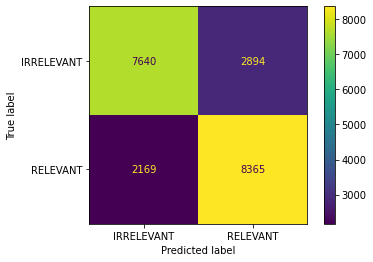

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3310 Acc: 0.8622
val Epoch Entropy: 0.8078
val Balanced Accuracy: 0.5000



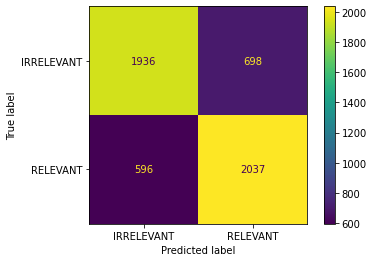

<Figure size 576x432 with 0 Axes>

Epoch 55/59
----------

train Loss: 0.4909 Acc: 0.7589
train Epoch Entropy: 0.7139
train Balanced Accuracy: 0.8333



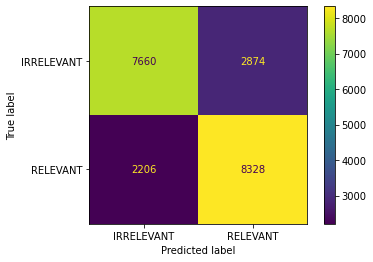

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3381 Acc: 0.8589
val Epoch Entropy: 0.8169
val Balanced Accuracy: 0.6667



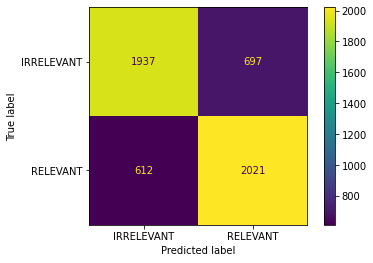

<Figure size 576x432 with 0 Axes>

Epoch 56/59
----------

train Loss: 0.4916 Acc: 0.7602
train Epoch Entropy: 0.7160
train Balanced Accuracy: 0.2500



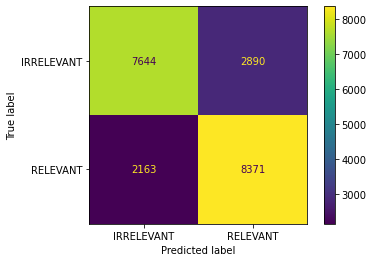

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3331 Acc: 0.8555
val Epoch Entropy: 0.8118
val Balanced Accuracy: 0.5000



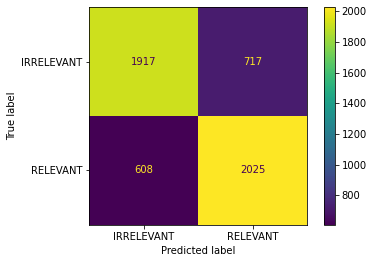

<Figure size 576x432 with 0 Axes>

Epoch 57/59
----------

train Loss: 0.4905 Acc: 0.7596
train Epoch Entropy: 0.7151
train Balanced Accuracy: 1.0000



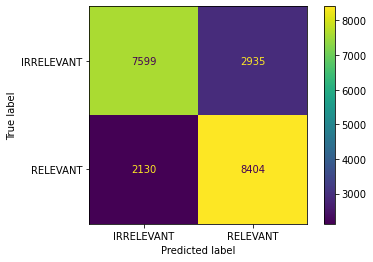

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3307 Acc: 0.8568
val Epoch Entropy: 0.8073
val Balanced Accuracy: 1.0000



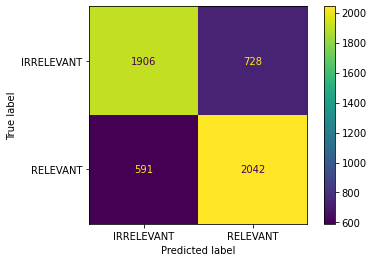

<Figure size 576x432 with 0 Axes>

Epoch 58/59
----------

train Loss: 0.4907 Acc: 0.7590
train Epoch Entropy: 0.7157
train Balanced Accuracy: 0.5000



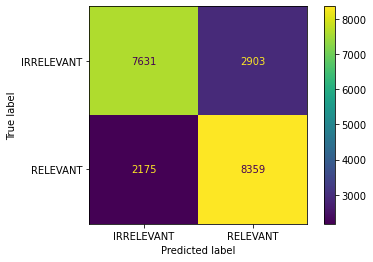

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3277 Acc: 0.8542
val Epoch Entropy: 0.8026
val Balanced Accuracy: 0.6667



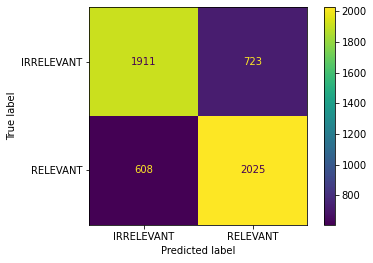

<Figure size 576x432 with 0 Axes>

Epoch 59/59
----------

train Loss: 0.4911 Acc: 0.7592
train Epoch Entropy: 0.7156
train Balanced Accuracy: 1.0000



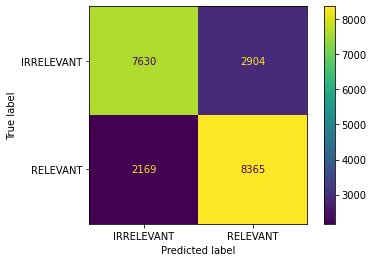

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3317 Acc: 0.8589
val Epoch Entropy: 0.8084
val Balanced Accuracy: 1.0000



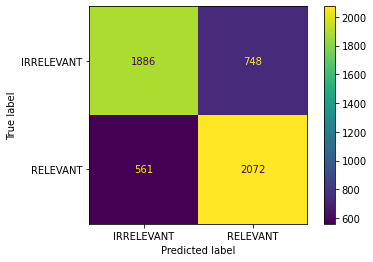

<Figure size 576x432 with 0 Axes>

Training complete in 304m 22s
Best val Acc: 0.863932
Best Val Acc. was achieved at epoch 15


In [23]:
model_list = []

for model_name in ['resnet']:
    
    print(model_name)
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    
    model_list.append(model)



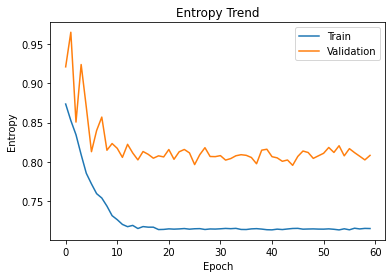

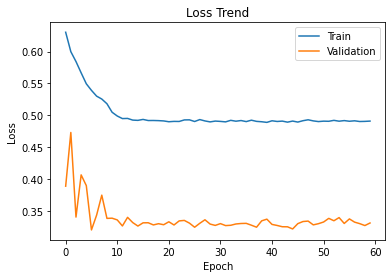

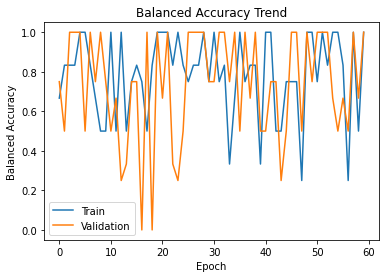

In [24]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

30
The Test Accuracy: tensor(0.8603, device='cuda:0')
The Test Balanced Accuracy: 0.7527969018932874
Skipped Inputs: 581


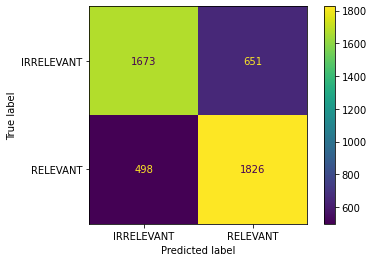

<Figure size 576x432 with 0 Axes>

35
The Test Accuracy: tensor(0.8571, device='cuda:0')
The Test Balanced Accuracy: 0.75
Skipped Inputs: 581


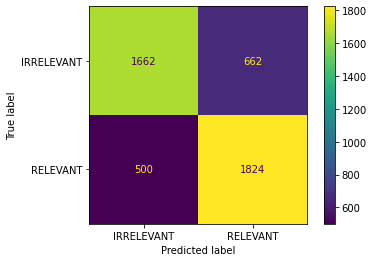

<Figure size 576x432 with 0 Axes>

40
The Test Accuracy: tensor(0.8586, device='cuda:0')
The Test Balanced Accuracy: 0.7512908777969018
Skipped Inputs: 581


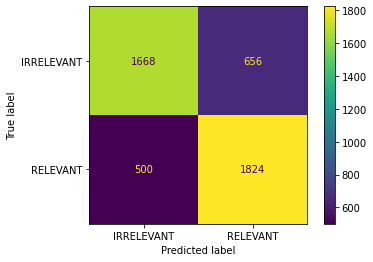

<Figure size 576x432 with 0 Axes>

60
The Test Accuracy: tensor(0.8591, device='cuda:0')
The Test Balanced Accuracy: 0.7517211703958692
Skipped Inputs: 581


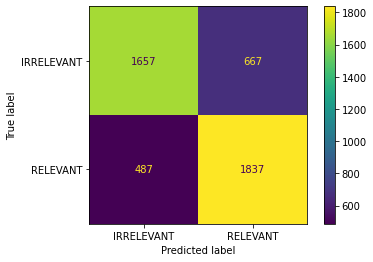

<Figure size 576x432 with 0 Axes>

75
The Test Accuracy: tensor(0.8456, device='cuda:0')
The Test Balanced Accuracy: 0.7398881239242685
Skipped Inputs: 581


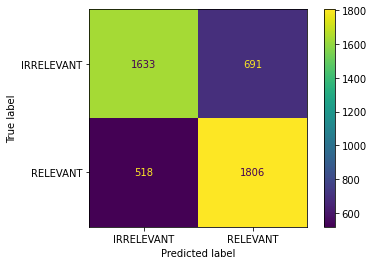

<Figure size 576x432 with 0 Axes>

In [25]:
for model in model_list:
    for hardness_threshold in [30,35,40,60,75]:
        print(hardness_threshold)
        test_model(model, testset, hardness_threshold)


In [33]:


def get_dataset_new(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset



In [38]:
trainset,valset,testset = get_dataset_new(path, val_size, test_size)
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

In [35]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.4939759036144578


Accuracy for SVM: 0.7512908777969018
Balanced Accuracy:0.7512908777969018


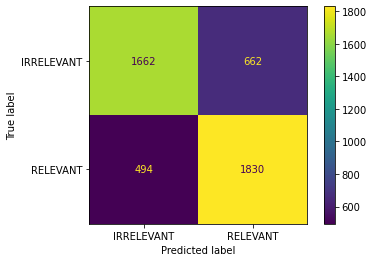

<Figure size 576x432 with 0 Axes>

In [36]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.7508605851979346
Balanced Accuracy:0.7508605851979346


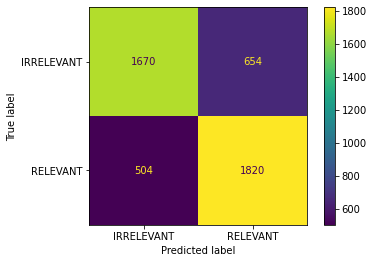

<Figure size 576x432 with 0 Axes>

In [37]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()